## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [1]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv
import random

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [291]:
# TODO: 1. Load images from folder into a list.

def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:

    #Intialize lists to hold images and labels
    images = []
    labels = []
    unique_labels = []
    d = dict()


    # Iterate through the directory structure and load images
    for label in os.listdir(set_dir):
        label_path = os.path.join(set_dir, label)
        if os.path.isdir(label_path):
            if not label in unique_labels:
                unique_labels.append(label)
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    if not label in d:
                        d[label] = []
                    d[label].append(img) 
            # If file isnt nested in a folder, it is considered as "NA" label
        else:
            img = cv2.imread(label_path)
            if img is not None:
                if not "NA" in d:
                    d["NA"] = []
                    unique_labels.append("NA")
                d["NA"].append(img)
                labels.append("NA")
    # If there is only one label then this is the test set
    if len(unique_labels) == 1:
        for label in unique_labels:
            images = d[label]
        return images, labels
    
    # If there are multiple labels we need to iterate through them to get desired structure
    while len(unique_labels) > 0:
                for label in unique_labels:
                    folder = d[label]
                    if len(folder) == 0:
                        unique_labels.remove(label)
                    else:
                        image = folder.pop(0)
                        d[label] = folder
                        images.append(image)
                        labels.append(label)    

    return images, labels


In [292]:
# Load images
images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

In [293]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    if not isinstance(images, list):
        return images


    processed_images = []

    for img in images:
        # Get image dimensions
        h, w, _ = img.shape

        # Resize shortest side to target_size
        scale = target_size / min(h, w)
        new_h = int(round(h * scale))
        new_w = int(round(w * scale))
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Center crop to (target_size, target_size)
        start_x = max((new_w - target_size) // 2, 0)
        start_y = max((new_h - target_size) // 2, 0)
        cropped = resized[start_y:start_y + target_size, start_x:start_x + target_size]

        # Final check
        if cropped.shape[0] != target_size or cropped.shape[1] != target_size:
            cropped = cv2.resize(cropped, (target_size, target_size), interpolation=cv2.INTER_AREA)

        processed_images.append(cropped)

    return np.stack(processed_images)

    

In [294]:
# Resize the images
images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [295]:
def normalize_images(images: np.ndarray) -> np.ndarray:

    if len(images) == 0:
        return np.empty((0, 224, 224, 3), dtype=np.float32)

    # Check image type and normalize accordingly (Only one type was encountered)
    if images.dtype == 'uint8':
        return images.astype(np.float32) / 255.0
    elif images.dtype == 'float32': 
        return images
    else:
        raise ValueError("Unexpected Type")
    

In [296]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

# Normalize the images
images_train = normalize_images(images_train)
images_val = normalize_images(images_val)
images_test = normalize_images(images_test)

In [297]:
def to_tensor_nchw(images: np.ndarray) -> torch.Tensor:
    """
    Convert a NumPy array from NHWC (N, H, W, C) to NCHW (N, C, H, W) and return as a float32 PyTorch tensor.

    Args:
        images: NumPy array with shape (N, H, W, C) and dtype float32

    Returns:
        A PyTorch tensor with shape (N, C, H, W) and dtype torch.float32
    """
    # Checks for correct shape and type
    if not isinstance(images, np.ndarray):
        raise TypeError("Input must be a NumPy array")
    if images.ndim != 4 or images.shape[-1] != 3:
        raise ValueError("Wrong Shape")

    # Convert from NHWC to NCHW
    images_nchw = np.transpose(images, (0, 3, 1, 2))  # (N, C, H, W)

    # Convert to PyTorch tensor
    return torch.from_numpy(images_nchw).float()

In [298]:
# TODO: 4. Convert data from NHWC to NCHW and create a PyTorch tensor from it.

tensor_train = to_tensor_nchw(images_train)
tensor_val = to_tensor_nchw(images_val)
tensor_test = to_tensor_nchw(images_test)

In [299]:
def compute_channel_stats(tensor: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Compute per-channel mean and std from a NCHW tensor.

    Args:
        tensor: PyTorch tensor of shape (N, C, H, W)

    Returns:
        mean: Tensor of shape (C,)
        std: Tensor of shape (C,)
    """
    if tensor.ndim != 4:
        raise ValueError("Input tensor must be in NCHW format")

    # We compute the mean and std across the batch and spatial dimensions
    # (0, 2, 3) means we compute mean/std for each channel
    mean = tensor.mean(dim=(0, 2, 3))
    std = tensor.std(dim=(0, 2, 3), unbiased=False)
    return mean, std


def standardize_tensor(tensor: torch.Tensor) -> torch.Tensor:
    """
    Standardize a tensor using per-channel mean and std.

    Args:
        tensor: Tensor of shape (N, C, H, W)
        mean: Per-channel mean (C,)
        std: Per-channel std (C,)

    Returns:
        Standardized tensor
    """
    mean, std = compute_channel_stats(tensor_train)
    return (tensor - mean[None, :, None, None]) / std[None, :, None, None]


In [300]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

train_mean, train_std = compute_channel_stats(tensor_train)


tensor_train = standardize_tensor(tensor_train)
tensor_val = standardize_tensor(tensor_val)
tensor_test = standardize_tensor(tensor_test)

In [301]:
def map_labels(tensor: torch.Tensor, image_labels: List[np.ndarray]) -> dict:
    """
    Create a mapping from each unique label to the list of indices where that label occurs.

    Args:
        tensor: A PyTorch tensor representing the dataset (not used inside function, 
                but included for context or possible future extension).
        image_labels: List of labels corresponding to each image in the dataset.

    Returns:
        index_map: Dictionary mapping each unique label to a list of indices in 
                   `image_labels` where that label is found.

    Example:
        image_labels = ['cat', 'dog', 'cat', 'bird']
        output = {'cat': [0, 2], 'dog': [1], 'bird': [3]}
    """
    index_map = {}  # Initialize empty dictionary

    # Iterate over all labels by their index
    for i in range(len(image_labels)):
        label = image_labels[i]
        
        if label in index_map:
            index_map[label].append(i)  # Append index if label key exists
        else:
            index_map[label] = [i]      # Create new list if first occurrence
    
    return index_map


In [302]:
# TODO: 6. Save the pre-processed sets as .pt files.

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.

torch.save(tensor_train, "tensor_train.pt")
torch.save(tensor_val, "tensor_val.pt")
torch.save(tensor_test, "tensor_test.pt")




In [303]:

# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }

unique_labels = np.unique(labels_train)

train_labels_index = map_labels(tensor_train, labels_train)
val_labels_index = map_labels(tensor_val, labels_val)

# 6.3 Map the labels to index.

label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

labels_train_index = torch.tensor([label_to_index[label] for label in labels_train])
labels_val_index = torch.tensor([label_to_index[label] for label in labels_val])

# 6.4 Save the index, label_to_index, and index_to_label.

torch.save(labels_train_index, "labels_train_index.pt")
torch.save(labels_val_index, "labels_val_index.pt")

torch.save(train_labels_index, "train_labels_index.pt")
torch.save(labels_val_index, "labels_val_index.pt")


In [304]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load("tensor_train.pt")
tensor_val = torch.load("tensor_val.pt")
tensor_test = torch.load("tensor_test.pt")

labels_train_index = torch.load("labels_train_index.pt")
labels_val_index = torch.load("labels_val_index.pt")

C:\Users\GGPC\AppData\Local\Temp\ipykernel_67748\295508795.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_train = torch.load("tensor_train.pt")
C:\Users\GGPC\App

# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [305]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [306]:
# TODO: 1. Set hyperparameters for the training process.

MAX_EPOCH = 32
INIT_LR = 1e-5      
BATCH_SIZE = 128

# Specify the training device (automatically detects GPU if available)
# Usage example: 
#   tensor = tensor.to(device)  # Moves tensor to selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [307]:
# TODO: 2. Create a pretrained ResNet34.

resnet34 = torchvision.models.resnet34(pretrained=True)
num_classes = 10
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)
resnet34 = resnet34.to(device)


c:\Users\GGPC\anaconda3\envs\MSA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\GGPC\anaconda3\envs\MSA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [308]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet34.parameters(), lr=INIT_LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True, min_lr=1e-6)


c:\Users\GGPC\anaconda3\envs\MSA\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [309]:
def random_horizontal_flip(batch, p=0.5):
    """
    batch: tensor of shape [B, C, H, W]
    p: probability of flipping each sample independently
    """
    if p <= 0.0:
        return batch
    B = batch.size(0)
    # one Bernoulli per sample
    mask = torch.rand(B, device=batch.device) < p
    if mask.any():
        batch[mask] = torch.flip(batch[mask], dims=[3])  # flip width dimension
    return batch


In [310]:
def random_crop_variable(batch, min_scale=0.8, max_scale=1.0):
    """
    Randomly crops each image in the batch with a random size.
    The crop size is a random fraction of the original size.
    
    min_scale: minimum fraction of original dimension to keep (e.g., 0.8)
    max_scale: maximum fraction (<= 1.0)
    """
    B, C, H, W = batch.shape
    cropped = torch.empty_like(batch)

    for i in range(B):
        # Randomly select crop size as a fraction of H/W
        scale = random.uniform(min_scale, max_scale)
        crop_h = int(H * scale)
        crop_w = int(W * scale)

        # Randomly choose top-left corner
        top = random.randint(0, H - crop_h)
        left = random.randint(0, W - crop_w)

        # Crop
        cropped_img = batch[i, :, top:top + crop_h, left:left + crop_w]

        # Resize back to original size
        cropped[i] = F.interpolate(cropped_img.unsqueeze(0), size=(H, W), mode='bilinear', align_corners=False)

    return cropped


In [311]:
def random_color_jitter(batch, brightness=0.2, contrast=0.2):
    """
    Apply random brightness and contrast adjustments to the batch.
    brightness/contrast: max +/- percentage change (e.g., 0.2 = +/- 20%)
    """
    B = batch.size(0)
    for i in range(B):
        img = batch[i]
        # Brightness
        if brightness > 0:
            factor = 1.0 + random.uniform(-brightness, brightness)
            img = img * factor
        # Contrast
        if contrast > 0:
            mean = img.mean(dim=(1, 2), keepdim=True)
            factor = 1.0 + random.uniform(-contrast, contrast)
            img = (img - mean) * factor + mean
        batch[i] = img.clamp(0, 1)  # keep values valid
    return batch

In [ ]:
def random_grayscale(batch: torch.Tensor, p=0.3) -> torch.Tensor:


    batch_out = batch.clone()
    N = batch.size(0)
    device = batch.device

    mask = torch.rand(N, device=device) < p  # Boolean mask for which images to grayscale

    if mask.any():
        # Convert selected images to grayscale by weighted sum of RGB channels
        rgb_weights = torch.tensor([0.2989, 0.5870, 0.1140], device=device).view(1, 3, 1, 1)
        gray_images = (batch_out[mask] * rgb_weights).sum(dim=1, keepdim=True)  # shape: (#gray, 1, H, W)
        batch_out[mask] = gray_images.repeat(1, 3, 1, 1)  # Repeat grayscale across all 3 channels

    return batch_out

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ImageNet normalization values
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device)
imagenet_std = torch.tensor([0.229, 0.224, 0.225], device=device)

def normalize(tensor):
    return (tensor - imagenet_mean[None, :, None, None]) / imagenet_std[None, :, None, None]


best_val_acc = 0.0
train_accs_resnet34, train_losses_resnet34 = [], []
val_accs_resnet34, val_losses_resnet34 = [], []

for epoch in range(MAX_EPOCH):
    # Training phase
    resnet34.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply augmentations ONLY on training data
        inputs = random_horizontal_flip(inputs, p=0.5)
        inputs = random_crop_variable(inputs, min_scale=0.2, max_scale=1.0)
        inputs = random_color_jitter(inputs, brightness=0.1, contrast=0.1)   
        inputs = random_grayscale(inputs, p=0.2)

        # Normalize inputs
        inputs = normalize(inputs)

        optimizer.zero_grad()
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation phase (no augmentation, just normalize)
    resnet34.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = normalize(inputs)

            outputs = resnet34(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Step LR scheduler based on validation loss
    scheduler.step(val_loss)

    train_accs_resnet34.append(train_acc)
    train_losses_resnet34.append(train_loss)
    val_accs_resnet34.append(val_acc)
    val_losses_resnet34.append(val_loss)

    print(f"Epoch {epoch+1}/{MAX_EPOCH} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model parameters
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet34.state_dict(), "resnet34_checkpoint.pkl")

Epoch 1/32 - Train Loss: 1.8298, Train Acc: 0.4174, Val Loss: 1.1184, Val Acc: 0.7662
Epoch 2/32 - Train Loss: 1.0785, Train Acc: 0.7121, Val Loss: 0.5639, Val Acc: 0.8885
Epoch 3/32 - Train Loss: 0.7936, Train Acc: 0.7773, Val Loss: 0.3721, Val Acc: 0.9215
Epoch 4/32 - Train Loss: 0.6609, Train Acc: 0.8038, Val Loss: 0.2854, Val Acc: 0.9362
Epoch 5/32 - Train Loss: 0.5728, Train Acc: 0.8282, Val Loss: 0.2415, Val Acc: 0.9454
Epoch 6/32 - Train Loss: 0.5388, Train Acc: 0.8346, Val Loss: 0.2098, Val Acc: 0.9481
Epoch 7/32 - Train Loss: 0.4962, Train Acc: 0.8468, Val Loss: 0.1843, Val Acc: 0.9546
Epoch 8/32 - Train Loss: 0.4666, Train Acc: 0.8562, Val Loss: 0.1758, Val Acc: 0.9562
Epoch 9/32 - Train Loss: 0.4440, Train Acc: 0.8595, Val Loss: 0.1689, Val Acc: 0.9542
Epoch 10/32 - Train Loss: 0.4385, Train Acc: 0.8624, Val Loss: 0.1597, Val Acc: 0.9585
Epoch 11/32 - Train Loss: 0.4129, Train Acc: 0.8691, Val Loss: 0.1628, Val Acc: 0.9604
Epoch 12/32 - Train Loss: 0.4007, Train Acc: 0.8704,

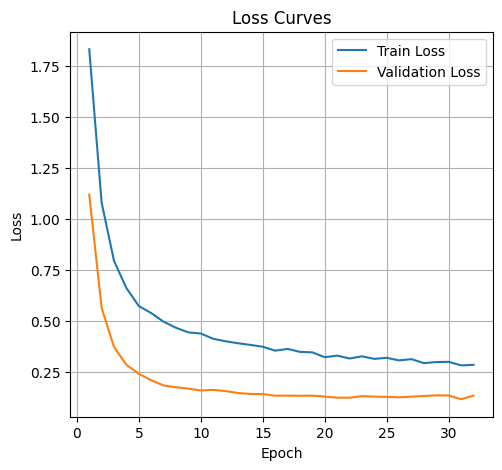

In [314]:
# TODO: 5. Plot the loss and accuracy curves.

epochs = range(1, MAX_EPOCH + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_resnet34, label='Train Loss')
plt.plot(epochs, val_losses_resnet34, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

plt.show()


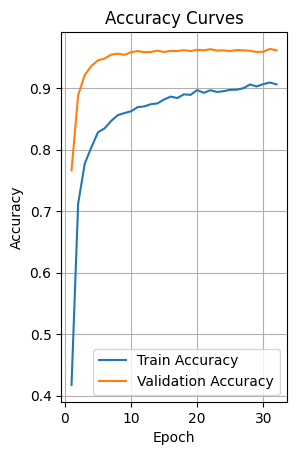

In [315]:

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_resnet34, label='Train Accuracy')
plt.plot(epochs, val_accs_resnet34, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

plt.show()

# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [ ]:

MAX_EPOCH = 64       # Number of epochs
INIT_LR = 0.0001      # Learning rate
BATCH_SIZE = 32       # Batch size
TEMPERATURE = 3.0     # Temperature for distillation
LOSS_RATIO = 0.5      # Ratio between distillation loss and classification loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:


student = torchvision.models.resnet18(weights=None)  # Non-pretrained
student.fc = nn.Linear(student.fc.in_features, num_classes)
student = student.to(device)

# (optional) quick check
num_params = sum(p.numel() for p in student.parameters())
num_trainable = sum(p.numel() for p in student.parameters() if p.requires_grad)
print(student.fc)
print(f"Total params: {num_params/1e6:.2f}M | Trainable: {num_trainable/1e6:.2f}M")
print(f"Model is on: {next(student.parameters()).device}")


Linear(in_features=512, out_features=10, bias=True)
Total params: 11.18M | Trainable: 11.18M
Model is on: cuda:0


In [ ]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

# Create ResNet34 architecture (must match the saved checkpoint)
resnet34 = torchvision.models.resnet34(pretrained=False)
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)

# Load the trained weights from checkpoint
resnet34.load_state_dict(torch.load("resnet34_checkpoint.pkl", map_location=device))

# Move to device and set to evaluation mode
resnet34 = resnet34.to(device)
resnet34.eval() 


c:\Users\GGPC\anaconda3\envs\MSA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\GGPC\AppData\Local\Temp\ipykernel_67748\2738683686.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.se

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:


import torch.nn.functional as F
# Optimizer for student
optimizer = torch.optim.Adam(student.parameters(), lr=INIT_LR)

# Standard classification loss
criterion_ce = nn.CrossEntropyLoss()

# KLDivLoss for distillation (student vs softened teacher outputs)
criterion_kd = nn.KLDivLoss(reduction='batchmean')

print("Optimizer and loss functions defined.")


Optimizer and loss functions defined.


In [320]:
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(MAX_EPOCH):
    student.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        
        inputs = random_horizontal_flip(inputs, p=0.5)
        inputs = random_crop_variable(inputs, min_scale=0.5, max_scale=1.0)  
        inputs = random_color_jitter(inputs, brightness=0.2, contrast=0.2)
        

        optimizer.zero_grad()
        
        # Student outputs (logits)
        student_outputs = student(inputs)
        
        # Teacher outputs (logits), no grad
        with torch.no_grad():
            teacher_outputs = resnet34(inputs)
        
        # Classification loss (hard labels)
        loss_ce = criterion_ce(student_outputs, labels)
        
        # Distillation loss (softened outputs)
        soft_student = F.log_softmax(student_outputs / TEMPERATURE, dim=1)
        soft_teacher = F.softmax(teacher_outputs / TEMPERATURE, dim=1)
        loss_kd = criterion_kd(soft_student, soft_teacher) * (TEMPERATURE ** 2)
        
        # Combined loss
        loss = LOSS_RATIO * loss_kd + (1 - LOSS_RATIO) * loss_ce
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(student_outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation phase
    student.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = student(inputs)
            loss_ce_val = criterion_ce(outputs, labels)
            val_loss += loss_ce_val.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{MAX_EPOCH} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model weights
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(student.state_dict(), "resnet18_checkpoint.pkl")


Epoch 1/64 - Train Loss: 2.6382, Train Acc: 0.3731, Val Loss: 2.8895, Val Acc: 0.1992
Epoch 2/64 - Train Loss: 2.0381, Train Acc: 0.5355, Val Loss: 3.0340, Val Acc: 0.2596
Epoch 3/64 - Train Loss: 1.8246, Train Acc: 0.5896, Val Loss: 2.3008, Val Acc: 0.2608
Epoch 4/64 - Train Loss: 1.6958, Train Acc: 0.6167, Val Loss: 2.5476, Val Acc: 0.3050
Epoch 5/64 - Train Loss: 1.6013, Train Acc: 0.6335, Val Loss: 2.5501, Val Acc: 0.2665
Epoch 6/64 - Train Loss: 1.5312, Train Acc: 0.6544, Val Loss: 2.4134, Val Acc: 0.3031
Epoch 7/64 - Train Loss: 1.4700, Train Acc: 0.6654, Val Loss: 2.4951, Val Acc: 0.2846
Epoch 8/64 - Train Loss: 1.4127, Train Acc: 0.6760, Val Loss: 1.9965, Val Acc: 0.3304
Epoch 9/64 - Train Loss: 1.3754, Train Acc: 0.6901, Val Loss: 2.0355, Val Acc: 0.3692
Epoch 10/64 - Train Loss: 1.3348, Train Acc: 0.6935, Val Loss: 2.3249, Val Acc: 0.2869
Epoch 11/64 - Train Loss: 1.2923, Train Acc: 0.7045, Val Loss: 2.1540, Val Acc: 0.3262
Epoch 12/64 - Train Loss: 1.2345, Train Acc: 0.7195,

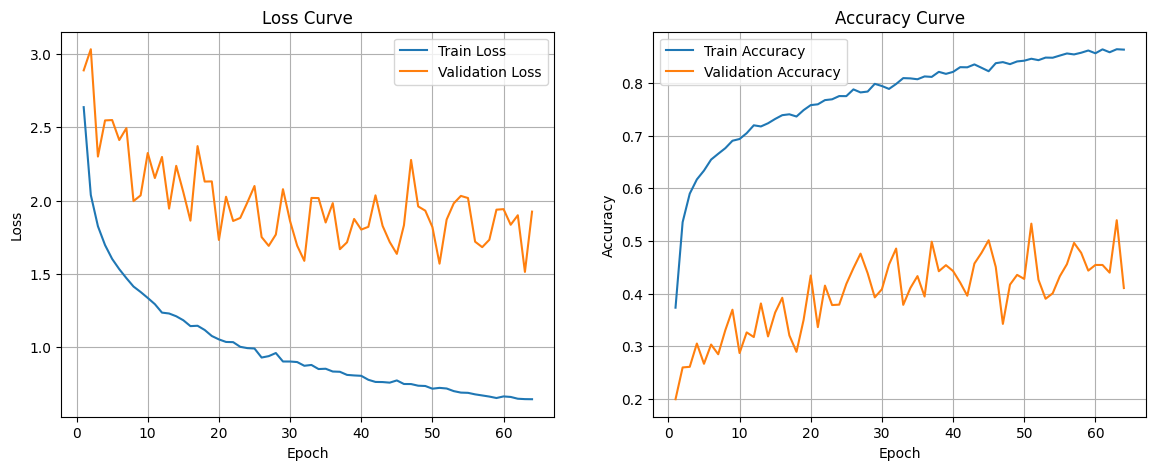

In [ ]:
import matplotlib.pyplot as plt

# Cell 6: Plot loss and accuracy curves

epochs = range(1, MAX_EPOCH + 1)

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()
print("")

# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [322]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.


resnet18 = torchvision.models.resnet18(weights=None)  # Non-pretrained ResNet18
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)  # Adjust output layer
resnet18.load_state_dict(torch.load("resnet18_checkpoint.pkl", map_location=device))  # Load trained weights
resnet18 = resnet18.to(device)
resnet18.eval()  # Set to evaluation mode to disable dropout/batchnorm updates



C:\Users\GGPC\AppData\Local\Temp\ipykernel_67748\2566703126.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load("resnet18_checkpoint.pkl"

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [323]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []

# Create DataLoader for test set (no shuffle)
test_dataset = TensorDataset(tensor_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

resnet18.eval()  # Ensure evaluation mode
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)  # TensorDataset returns tuple
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())  # Store predictions as list


In [324]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...


index_to_label = {i: name for i, name in enumerate(unique_labels)}


with open("submission.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["file_name", "label"])

    for idx, pred in enumerate(predictions):
        label_name = index_to_label[pred]
        writer.writerow([f"{idx}.jpg", label_name])